# Blind Docking

In [1]:
from pymol import cmd
import py3Dmol

from openbabel import pybel

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem,rdFMCS, Draw

import sys, os, random, time
sys.path.insert(1, 'utilities/')

from multiprocessing import Pool

from utils import getbox, generate_ledock_file, dok_to_sdf

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

### Setting the working directory

In [2]:
os.chdir('test/Blind_Docking/')

### Loading the system from PDB

In [3]:
cmd.fetch(code='1XOZ',type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='Lig',selection='organic')
cmd.save(filename='1XOZ_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename='1XOZ_lig.mol2',format='mol2',selection='Lig')
cmd.delete('all')

### Protein sanitization

In [4]:
!../../bin/lepro_linux_x86 {'1XOZ_clean.pdb'}

os.rename('pro.pdb','1XOZ_clean_H.pdb') # Output from lepro is pro.pdb, this line will change the name to '1XOZ_clean_H.pdb'

### Ligand sanitization

RDKit WARNING: [15:34:41] 1XOZ: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit ERROR: [15:34:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit ERROR: 


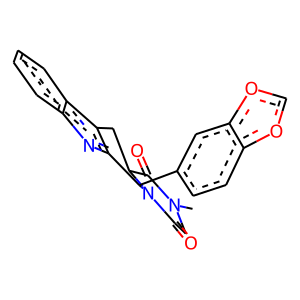

In [5]:
m=Chem.MolFromMol2File('1XOZ_lig.mol2',False)
Draw.MolToImage(m)

In [6]:
mol= [m for m in pybel.readfile(filename='1XOZ_lig.mol2',format='mol2')][0]
mol.addh()
out=pybel.Outputfile(filename='1XOZ_lig_H.mol2',format='mol2',overwrite=True)
out.write(mol)
out.close()

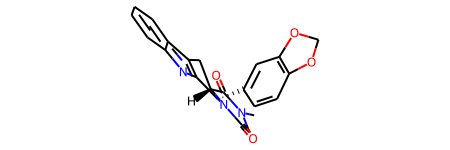

In [7]:
m=Chem.MolFromMol2File('1XOZ_lig_H.mol2')
m

### System visualization

In [8]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open('1XOZ_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Molecular docking

### Protein pockets identification

In [9]:
!../../bin/fpocket -f {'1XOZ_clean_H.pdb'} -d > {'pocket_descriptors.csv'}

In [10]:
pockets_data=pd.read_csv('pocket_descriptors.csv',sep=' ',index_col=[0])
pockets_data

,drug_score,volume,nb_asph,inter_chain,apol_asph_proportion,mean_asph_radius,as_density,mean_asph_solv_acc,mean_loc_hyd_dens,flex,...,val,trp,tyr,chain_1_type,chain_2_type,num_res_chain_1,num_res_chain_2,lig_het_tag,name_chain_1,name_chain_2
cav_id,,,,,,,,,,,,,,,,,,,,,
1,0.8741,1043.9214,139,0,0.6331,4.0200,6.8663,0.4647,60.2955,0.0,...,0,1,2,0,0,324,324,NaN,A,A
2,0.0452,563.1164,72,0,0.3333,3.7437,5.5622,0.4716,19.5833,0.0,...,0,1,0,0,0,324,324,NaN,A,A
3,0.0003,513.0750,37,0,0.3243,4.0605,5.1642,0.5894,10.6667,0.0,...,0,0,1,0,0,324,324,NaN,A,A
4,0.0021,372.0898,30,0,0.4667,3.9872,4.2452,0.6120,11.7143,0.0,...,0,0,0,0,0,324,324,NaN,A,A
5,0.0009,109.2874,23,0,0.3913,3.5100,2.0155,0.3504,8.0000,0.0,...,0,0,0,0,0,324,324,NaN,A,A
6,0.0046,234.3679,34,0,0.4706,3.8398,3.2787,0.4623,15.0000,0.0,...,0,1,0,0,0,324,324,NaN,A,A
7,0.0005,222.4149,16,0,0.6250,3.9237,2.4631,0.6783,9.0000,0.0,...,0,0,0,0,0,324,324,NaN,A,A
8,0.0004,215.9997,15,0,0.2667,3.9367,2.9664,0.5179,3.0000,0.0,...,0,1,0,0,0,324,324,NaN,A,A
9,0.0012,270.2740,33,0,0.6061,4.1402,2.1593,0.6400,19.0000,0.0,...,0,0,0,0,0,324,324,NaN,A,A


### Pockets visualization

In [11]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
#view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1XOZ_lig_H.mol2','r').read(),'mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.1}})


for file in os.listdir(path='1XOZ_clean_H_out/'):
    if '.pqr' in file:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(open('1XOZ_clean_H_out/'+file,'r').read(),'pqr')
        x = view.getModel()
        x.setStyle({},{'sphere':{'color':color[0],'opacity':0.6}}) 
        
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Per-pocket docking box set up (vina)

Hint: You may think about extending the pocket box by 4-5 armostrongs ...

In [12]:
for file in os.listdir('1XOZ_clean_H_out/'):
    if 'pqr' in file:
        pocket_num=int(file.split('_')[0].replace('pocket',''))
        cmd.load(filename='1XOZ_clean_H_out/'+file,format='pqr',object=pocket_num)
        
        center,size=getbox(selection=pocket_num,extending=5.0,software='vina')
        
        pockets_data.loc[pocket_num,'center_x']=center['center_x']
        pockets_data.loc[pocket_num,'center_y']=center['center_y']
        pockets_data.loc[pocket_num,'center_z']=center['center_z']
        
        pockets_data.loc[pocket_num,'size_x']=size['size_x']
        pockets_data.loc[pocket_num,'size_y']=size['size_y']
        pockets_data.loc[pocket_num,'size_z']=size['size_z']
        
        cmd.delete('all')

In [13]:
pockets_data.head(10)

,drug_score,volume,nb_asph,inter_chain,apol_asph_proportion,mean_asph_radius,as_density,mean_asph_solv_acc,mean_loc_hyd_dens,flex,...,num_res_chain_2,lig_het_tag,name_chain_1,name_chain_2,center_x,center_y,center_z,size_x,size_y,size_z
cav_id,,,,,,,,,,,,,,,,,,,,,
1,0.8741,1043.9214,139,0,0.6331,4.0200,6.8663,0.4647,60.2955,0.0,...,324,NaN,A,A,47.153002,36.187000,15.229000,20.326000,18.056000,24.312000
2,0.0452,563.1164,72,0,0.3333,3.7437,5.5622,0.4716,19.5833,0.0,...,324,NaN,A,A,39.917500,46.822001,12.002500,18.320999,23.436001,15.865001
3,0.0003,513.0750,37,0,0.3243,4.0605,5.1642,0.5894,10.6667,0.0,...,324,NaN,A,A,24.391001,19.912000,19.753000,18.076000,18.219999,19.172001
4,0.0021,372.0898,30,0,0.4667,3.9872,4.2452,0.6120,11.7143,0.0,...,324,NaN,A,A,26.427000,30.581500,35.598000,17.528000,16.167002,16.634003
5,0.0009,109.2874,23,0,0.3913,3.5100,2.0155,0.3504,8.0000,0.0,...,324,NaN,A,A,33.264500,32.007500,29.854000,13.457001,13.223000,11.883999
6,0.0046,234.3679,34,0,0.4706,3.8398,3.2787,0.4623,15.0000,0.0,...,324,NaN,A,A,38.223499,29.394000,29.178499,11.913002,12.837999,17.578999
7,0.0005,222.4149,16,0,0.6250,3.9237,2.4631,0.6783,9.0000,0.0,...,324,NaN,A,A,35.526501,15.045000,26.638000,15.500999,11.122000,12.118000
8,0.0004,215.9997,15,0,0.2667,3.9367,2.9664,0.5179,3.0000,0.0,...,324,NaN,A,A,28.457500,48.134499,40.513498,14.118999,13.151001,14.659000
9,0.0012,270.2740,33,0,0.6061,4.1402,2.1593,0.6400,19.0000,0.0,...,324,NaN,A,A,33.537000,17.919500,15.523000,14.968000,13.763000,13.890000


### Docking with Smina

In [14]:
for pocket in pockets_data.index:
    rec = '1XOZ_clean_H.pdb' 
    lig = '1XOZ_lig_H.mol2'
    outfile = 'smina_outfiles/1XOZ_lig_pocket_'+str(pocket)+'.sdf'
    center_x = pockets_data.loc[pocket,'center_x']
    center_y = pockets_data.loc[pocket,'center_y']
    center_z = pockets_data.loc[pocket,'center_z']
    size_x = pockets_data.loc[pocket,'size_x']
    size_y = pockets_data.loc[pocket,'size_y']
    size_z = pockets_data.loc[pocket,'size_z']
    
    !../../bin/smina -r {rec} -l {lig} -o {outfile} --center_x {center_x} --center_y {center_y} --center_z {center_z} --size_x {size_x} --size_y {size_y} --size_z {size_z} --exhaustiveness 8 --num_modes 5 >> {'smina.log'}

In [20]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
#view.addSurface(py3Dmol.VDW,{'opacity':0.8,'color':'white'})


view.addModel(open('1XOZ_lig_H.mol2','r').read(),'mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.1}})


for file in os.listdir(path='1XOZ_clean_H_out/'):
    if '.pqr' in file:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(open('1XOZ_clean_H_out/'+file,'r').read(),'pqr')
        x = view.getModel()
        x.setStyle({},{'sphere':{'color':color[0],'opacity':0.5}})
        
for file in os.listdir('smina_outfiles/'):
        poses=Chem.SDMolSupplier('smina_outfiles/'+file)
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        for pose in poses:
            p=Chem.MolToMolBlock(pose)
            view.addModel(p,'mol')
            z=view.getModel()
            z.setStyle({},{'stick':{'color':color[0],'radius':0.05}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Docking with Ledock

### Per-pocket docking box set up (Ledock)

In [16]:
for file in os.listdir('1XOZ_clean_H_out/'):
    if 'pqr' in file:
        
        pocket_num=int(file.split('_')[0].replace('pocket',''))
        cmd.load(filename='1XOZ_clean_H_out/'+file,format='pqr',object=pocket_num)
        
        X,Y,Z=getbox(selection=pocket_num,extending=5.0,software='ledock')
        
        pockets_data.loc[pocket_num,'minX']=X['minX']
        pockets_data.loc[pocket_num,'maxX']=X['maxX']
        
        pockets_data.loc[pocket_num,'minY']=Y['minY']
        pockets_data.loc[pocket_num,'maxY']=Y['maxY']
        
        pockets_data.loc[pocket_num,'minZ']=Z['minZ']
        pockets_data.loc[pocket_num,'maxZ']=Z['maxZ']
        
        cmd.delete('all')

In [17]:
pockets_data.head(10)

,drug_score,volume,nb_asph,inter_chain,apol_asph_proportion,mean_asph_radius,as_density,mean_asph_solv_acc,mean_loc_hyd_dens,flex,...,center_z,size_x,size_y,size_z,minX,maxX,minY,maxY,minZ,maxZ
cav_id,,,,,,,,,,,,,,,,,,,,,
1,0.8741,1043.9214,139,0,0.6331,4.0200,6.8663,0.4647,60.2955,0.0,...,15.229000,20.326000,18.056000,24.312000,36.990002,57.316002,27.159000,45.215000,3.073000,27.385000
2,0.0452,563.1164,72,0,0.3333,3.7437,5.5622,0.4716,19.5833,0.0,...,12.002500,18.320999,23.436001,15.865001,30.757000,49.077999,35.104000,58.540001,4.070000,19.935000
3,0.0003,513.0750,37,0,0.3243,4.0605,5.1642,0.5894,10.6667,0.0,...,19.753000,18.076000,18.219999,19.172001,15.353001,33.429001,10.802000,29.021999,10.167000,29.339001
4,0.0021,372.0898,30,0,0.4667,3.9872,4.2452,0.6120,11.7143,0.0,...,35.598000,17.528000,16.167002,16.634003,17.663000,35.191000,22.497999,38.665001,27.280998,43.915001
5,0.0009,109.2874,23,0,0.3913,3.5100,2.0155,0.3504,8.0000,0.0,...,29.854000,13.457001,13.223000,11.883999,26.535999,39.993000,25.396000,38.618999,23.912001,35.796000
6,0.0046,234.3679,34,0,0.4706,3.8398,3.2787,0.4623,15.0000,0.0,...,29.178499,11.913002,12.837999,17.578999,32.266998,44.180000,22.975000,35.813000,20.389000,37.967999
7,0.0005,222.4149,16,0,0.6250,3.9237,2.4631,0.6783,9.0000,0.0,...,26.638000,15.500999,11.122000,12.118000,27.776001,43.277000,9.484000,20.606000,20.579000,32.697001
8,0.0004,215.9997,15,0,0.2667,3.9367,2.9664,0.5179,3.0000,0.0,...,40.513498,14.118999,13.151001,14.659000,21.398001,35.517000,41.558998,54.709999,33.183998,47.842999
9,0.0012,270.2740,33,0,0.6061,4.1402,2.1593,0.6400,19.0000,0.0,...,15.523000,14.968000,13.763000,13.890000,26.052999,41.021000,11.038000,24.801001,8.578000,22.468000


In [21]:
for pocket in pockets_data.index:
    generate_ledock_file(receptor='1XOZ_clean_H.pdb',
                         l_list='1XOZ_lig_H.mol2',
                         l_list_outfile='ligand.list',
                         x=[pockets_data.loc[pocket,'minX'],pockets_data.loc[pocket,'maxX']],
                         y=[pockets_data.loc[pocket,'minY'],pockets_data.loc[pocket,'maxY']],
                         z=[pockets_data.loc[pocket,'minZ'],pockets_data.loc[pocket,'maxZ']],
                         n_poses=5,
                         rmsd=1.0,
                         out='dock.in')
    
    !../../bin/ledock_linux_x86 dock.in
    
    os.rename('1XOZ_lig_H.dok','ledock_outfiles/1XOZ_ledock_pock_'+str(pocket)+'.dok')

In [22]:
for file in os.listdir('ledock_outfiles/'):
    if 'dok' in file:
        dok_to_sdf(dok_file='ledock_outfiles/'+file,output='ledock_outfiles/'+file.replace('dok','sdf'))

In [23]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
#view.addSurface(py3Dmol.VDW,{'opacity':0.8,'color':'white'})


view.addModel(open('1XOZ_lig_H.mol2','r').read(),'mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.1}})

### Loading the pockets ###

for file in os.listdir(path='1XOZ_clean_H_out/'):
    if '.pqr' in file:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(open('1XOZ_clean_H_out/'+file,'r').read(),'pqr')
        x = view.getModel()
        x.setStyle({},{'sphere':{'color':color[0],'opacity':0.5}})
        
### Loading the docking results ###  

for file in os.listdir('ledock_outfiles/'):
    if 'sdf' in file:
        poses=Chem.SDMolSupplier('ledock_outfiles/'+file)
        for pose in poses:
            p=Chem.MolToMolBlock(pose)
            color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
            view.addModel(p,'mol')
            z= view.getModel()
            z.setStyle({},{'stick':{'color':color[0],'radius':0.05}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol